Benchmark of 4 feature selection techniques: HSIC Lasso, Block HSIC Lasso, mRMR and LASSO. For different combinations we generated synthetic data of varying numbers of samples *n* (100, 1000, 10000) and numbers of features *d* (1000, 2500, 5000, 10000). We selected a variable number of causal features (10, 50, 100), and we combined them non-linearly to obtain the output vector. Applying the above methods, we tried to recover the original causal features. For each experimental condition, we generated 10 replicates.

* LASSO features are incorrectly displayed.
* Error bars are not displayed, as the variance is pretty high for all the examples and difficults readability.

In [1]:
library(tidyverse)
library(cowplot)

palette = c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
            'HSIC Lasso, B = 40' = '#e7298a', 'HSIC Lasso, B = 30' = '#ce1256',
            'HSIC Lasso, B = 20' = '#980043', 'HSIC Lasso, B = 10' = '#67001f',
            'Lasso' = '#2171b5', 'mRMR' = '#238443')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Feature selection

First, we evaluate the ability of each algorithm to recover the causal features.

In [2]:
features <- read_tsv('../results/benchmark/feature_selection.tsv', col_types = 'cddiid') %>%
    mutate(model = gsub('hsic_lasso-b0', 'HSIC Lasso', model),
           model = gsub('hsic_lasso', 'HSIC Lasso', model),
           model = gsub('-b', ', B = ', model),
           model = gsub('lasso', 'Lasso', model)) %>%
    group_by(model, n, d, c) %>%
    summarize(sd = sd(TPR), TPR = mean(TPR), ended = n()) %>%
    ungroup

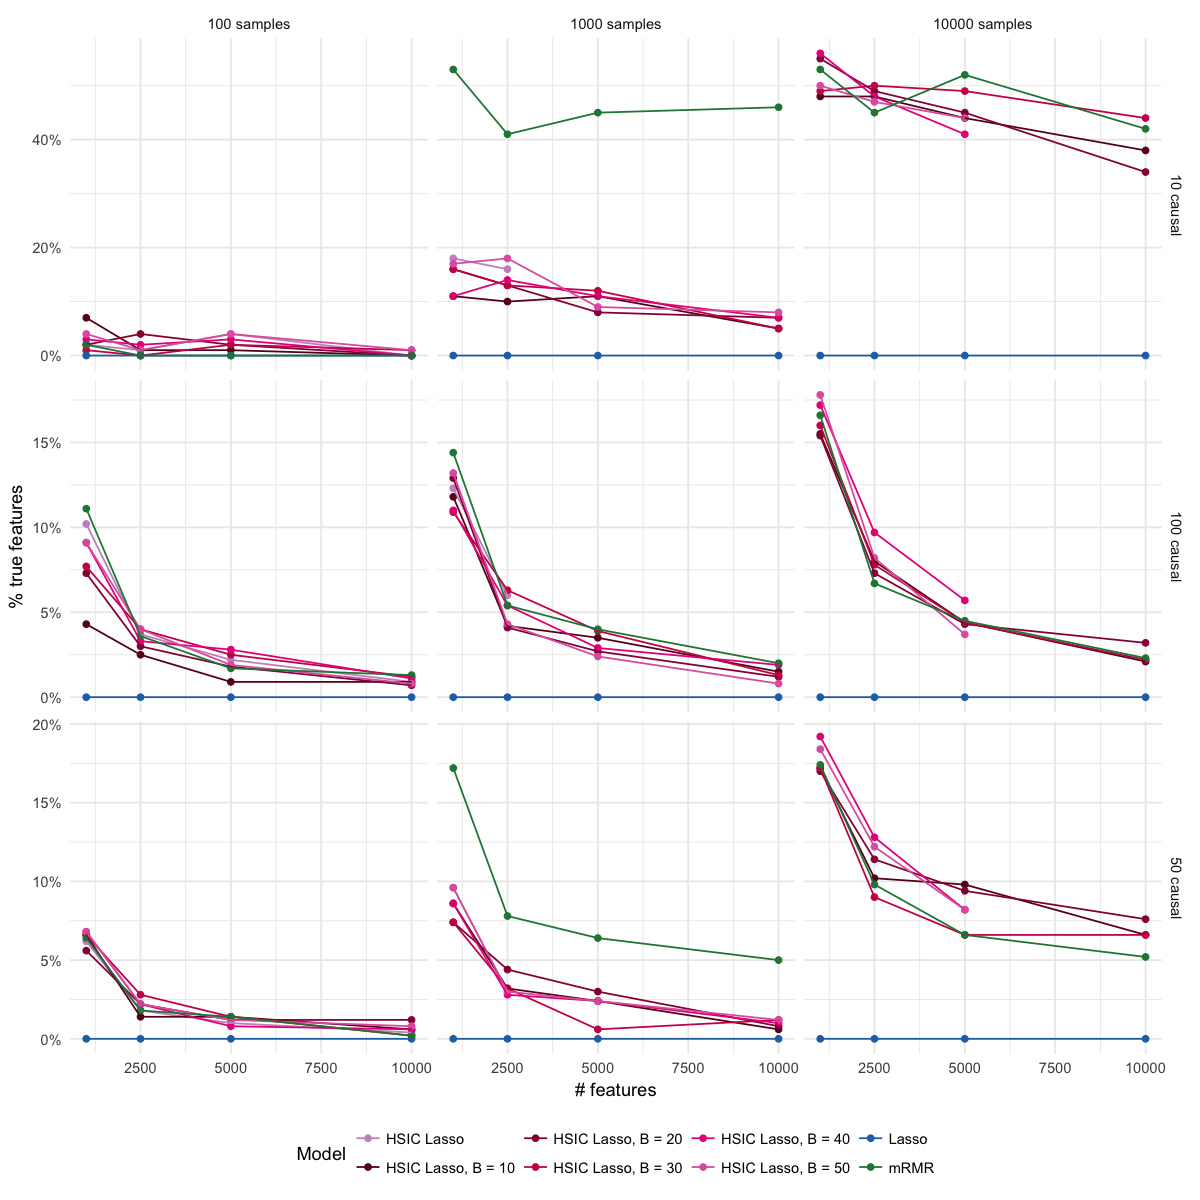

In [3]:
options(repr.plot.width=10, repr.plot.height=10)
features %>%
    mutate(n = paste(n, 'samples'),
           c = paste(c, 'causal')) %>%
    ggplot(aes(x = d, y = TPR, color = model)) +
#         geom_errorbar(aes(ymin = TPR - sd, ymax = TPR + sd)) +
        geom_point() +
        geom_line() +
        theme_minimal() +
        theme(legend.position = 'bottom') +
        labs(x = '# features', y = '% true features', color = 'Model') +
        facet_grid(c ~ n, scales = 'free') + 
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = palette)

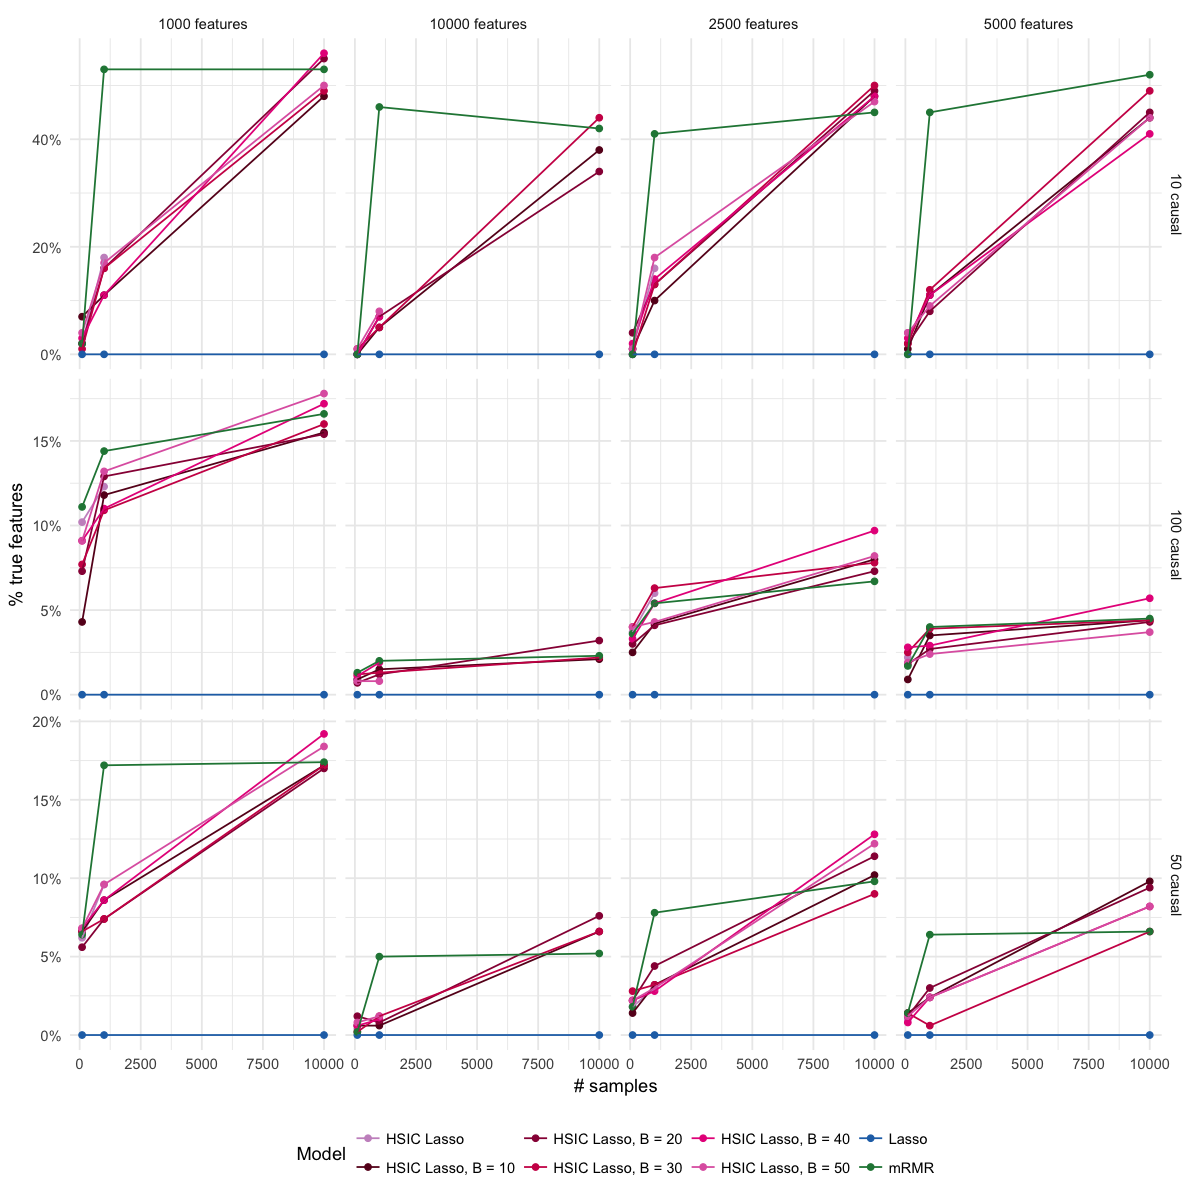

In [4]:
options(repr.plot.width=10, repr.plot.height=10)
features %>%
    mutate(d = paste(d, 'features'),
           c = paste(c, 'causal')) %>%
    ggplot(aes(x = n, y = TPR, color = model)) +
#         geom_errorbar(aes(ymin = TPR - sd, ymax = TPR + sd)) +
        geom_point() +
        geom_line() +
        theme_minimal() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = '% true features', color = 'Model') +
        facet_grid(c ~ d, scales = 'free') + 
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = palette)

HSIC LASSO is able to recover a comparable proportion of the causal features in most experimental settings. mRMR does exceptionally well at 1,000 samples, and then reaches a plateau. Still, we are recovering a relatively low proportion of the causal features (<50%). 

Interestingly, block size seems to not play an important role, meaning that smaller block sizes (10, 20) provide approximately an estimate as good as bigger block sizes.

# Computational feasibility

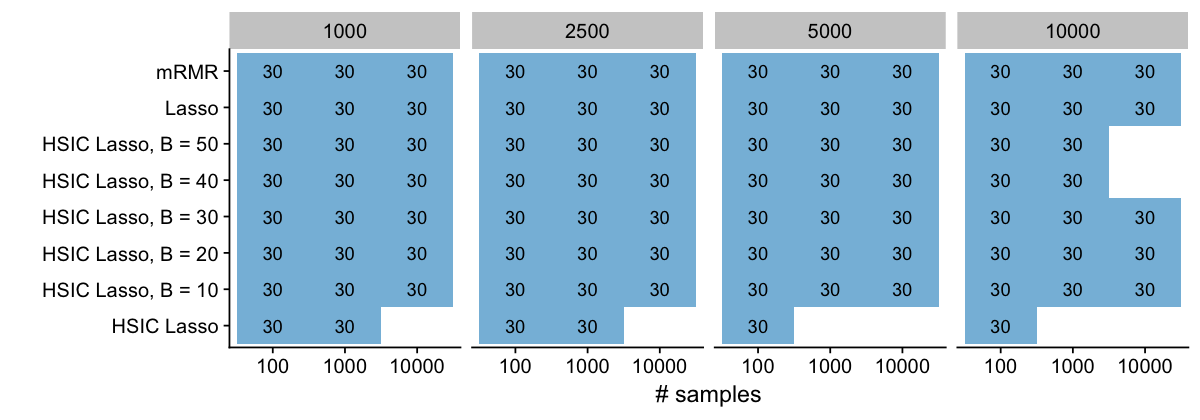

In [5]:
options(repr.plot.width=10, repr.plot.height=3.5)
features %>%
    group_by(model, n, d) %>%
    summarize(ended = sum(ended)) %>%
    ggplot(aes(x = as.character(n), y = model, fill = ended, label = ended)) +
        geom_tile() +
        geom_text() +
        facet_grid(. ~ d) +
        theme(legend.position = 'none') +
        labs(x = '# samples', y = '') + 
        scale_fill_distiller()

Computational resources were not tightly controlled, but we placed a a hard limit of 50GBs on memory consumption. When that memory was exceeded, jobs were killed. Above plot shows which jobs went over the limit: original HSIC lasso and the ones with larger blocks in the most difficult settings (large n, large d).

# Prediction accuracy

We fitted a kernelized SVR to the features selected by mRMR and HSIC lasso. Then we measured the accuracy of the prediction as R<sup>2</sup> w.r.t. the output vector.

In [6]:
prediction <- read_tsv('../results/benchmark/prediction.tsv', col_types = 'cddiid') %>%
    mutate(model = gsub('hsic_lasso-b0', 'HSIC Lasso', model),
           model = gsub('hsic_lasso', 'HSIC Lasso', model),
           model = gsub('-b', ', B = ', model),
           model = gsub('lasso', 'Lasso', model)) %>%
    group_by(model, n, c, d) %>%
    summarize(sd = sd(r2), r2 = mean(r2), ended = n()) %>%
    ungroup

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

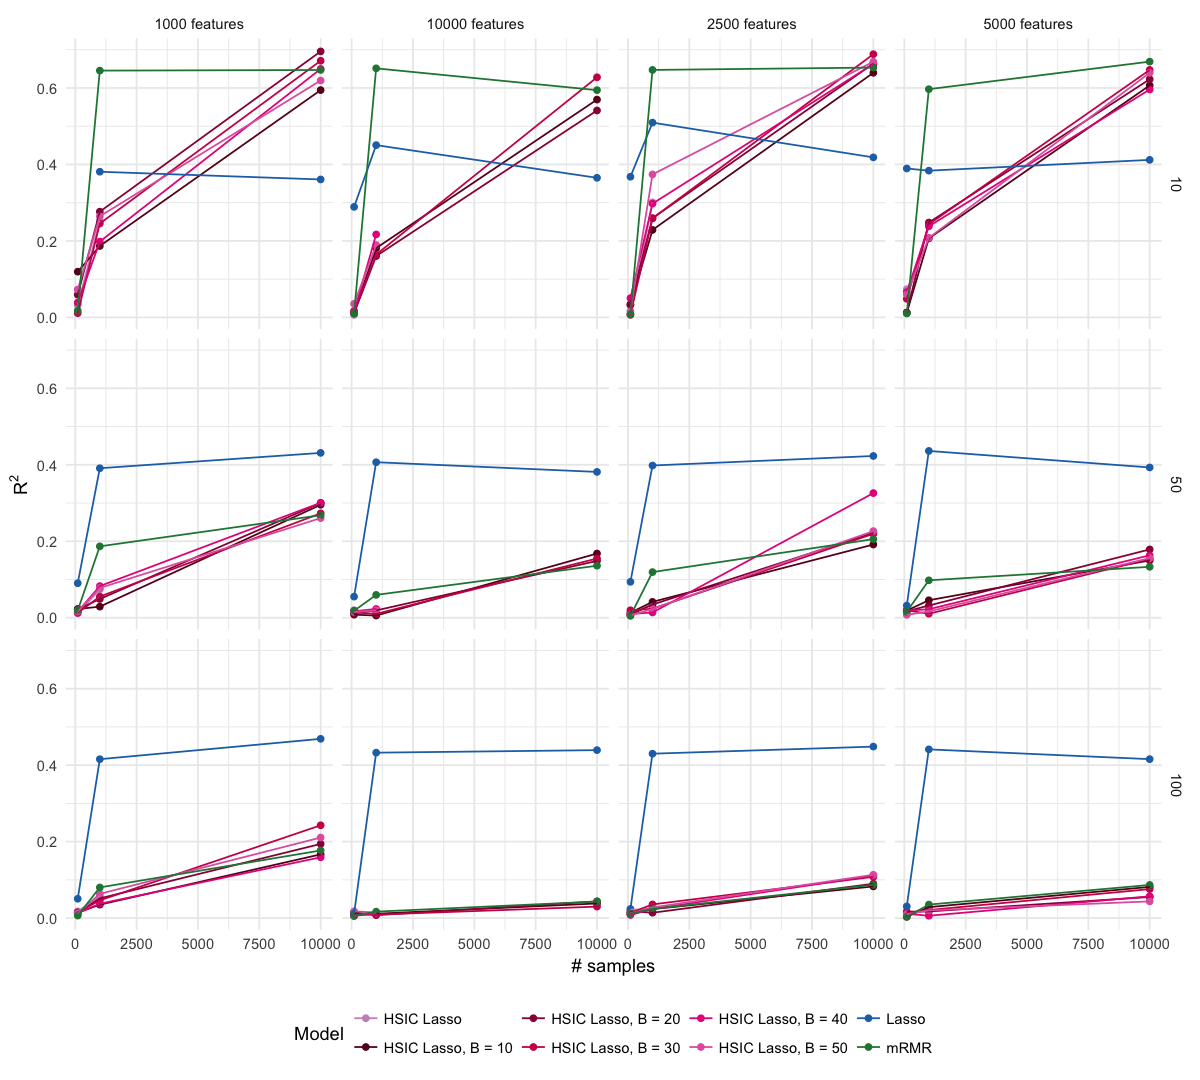

In [7]:
options(repr.plot.width=10, repr.plot.height=9)
prediction %>%
    mutate(d = paste(d, 'features')) %>%
    ggplot(aes(x = n, y = r2, color = model)) +
#         geom_errorbar(aes(ymin = r2 - sd, ymax = r2 + sd)) +
        geom_point() +
        geom_line() +
        theme_minimal() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = expression(R^2), color = 'Model') +
        facet_grid(c ~ d) +
        scale_color_manual(values = palette)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

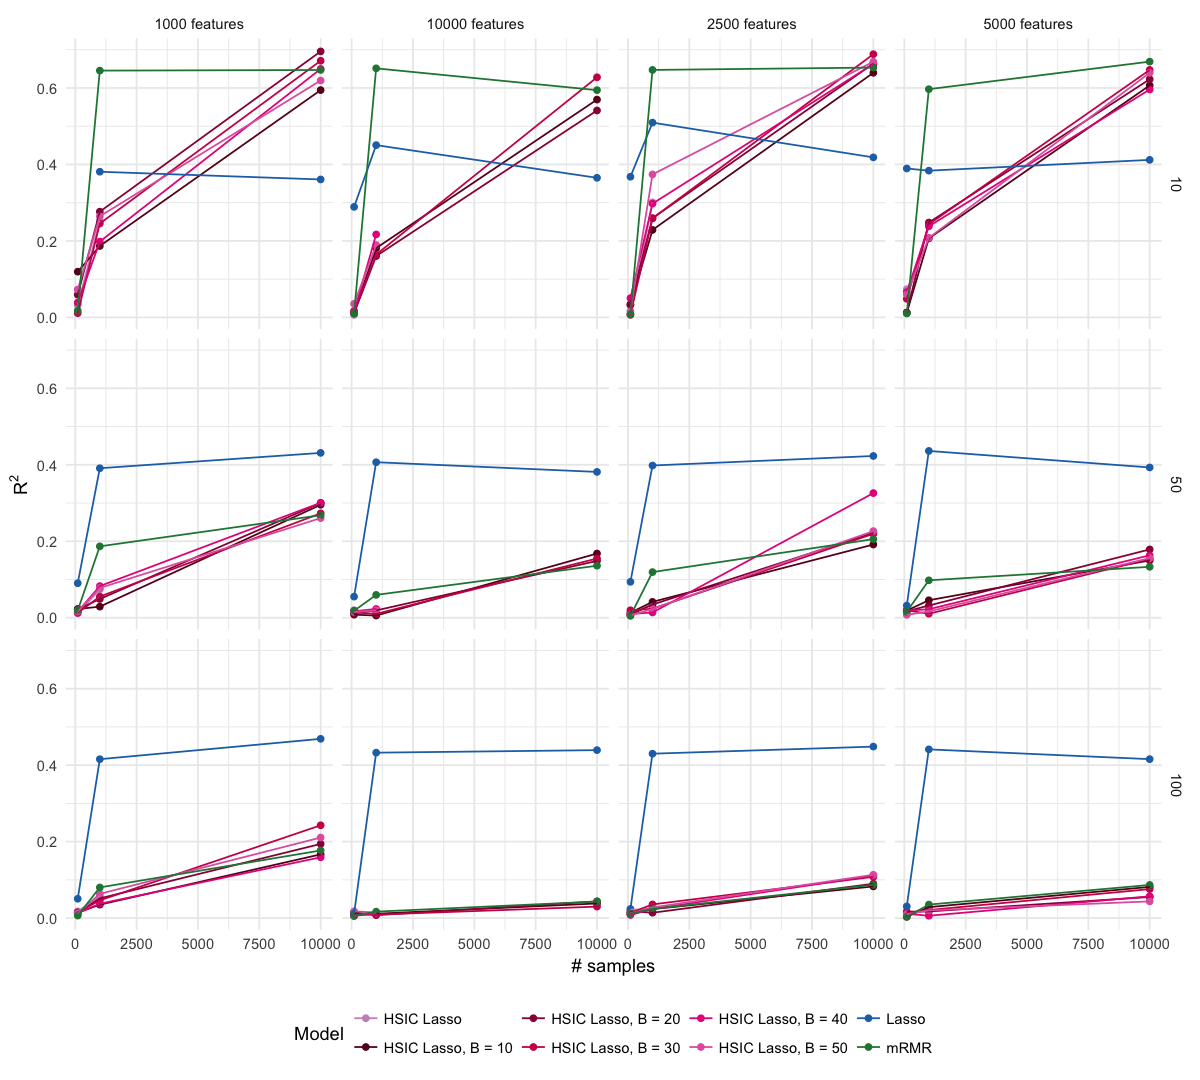

In [8]:
options(repr.plot.width=10, repr.plot.height=9)
prediction %>%
    mutate(d = paste(d, 'features')) %>%
    ggplot(aes(x = n, y = r2, color = model)) +
#         geom_errorbar(aes(ymin = r2 - sd, ymax = r2 + sd)) +
        geom_point() +
        geom_line() +
        theme_minimal() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = expression(R^2), color = 'Model') +
        facet_grid(c ~ d) +
        scale_color_manual(values = palette)

LASSO outperforms all of the others; the non, linear methods stay competitive among them. Maybe this shows that the problem is not as hard as we would like it to be.